In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('yfinance_close.csv')[['Date', 'ITC.NS']]

df.head()

,Date,ITC.NS
0,2022-10-03,292.618378
1,2022-10-04,300.240540
2,2022-10-06,303.668274
3,2022-10-07,301.368073
4,2022-10-10,295.730438


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
import matplotlib.dates as mdates

# Load and prepare data
df = pd.read_csv('yfinance_close.csv', parse_dates=['Date'])
df = df[['Date', 'NATIONALUM.NS']].rename(columns={'NATIONALUM.NS': 'Close'})
df = df.set_index('Date').sort_index()

# Plot function for a 3-month window ending at the selected date
def plot_window(end_date):
    end = pd.to_datetime(end_date)
    start = end - pd.DateOffset(months=2)

    window = df.loc[df.index.to_series().between(start, end)]
    if window.empty:
        print("No data in window. Pick a later end date.")
        return

    plt.figure(figsize=(10, 4))
    plt.plot(window.index, window['Close'], color='steelblue')
    plt.title(f'NATIONALUM.NS Close — {start.date()} to {end.date()}')
    plt.ylabel('Close')
    plt.xlabel('Date')
    plt.grid(True, alpha=0.3)

    ax = plt.gca()
    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
    plt.tight_layout()
    plt.show()

# Slider over available dates to choose the window end
end_slider = widgets.SelectionSlider(
    options=list(df.index),
    value=df.index[-1],
    description='End',
    orientation='horizontal',
    layout={'width': '800px'}
)

interact(plot_window, end_date=end_slider)

interactive(children=(SelectionSlider(description='End', index=739, layout=Layout(width='800px'), options=(Tim…

<function __main__.plot_window(end_date)>

# ChatGPT edition!

In [33]:

import pandas as pd
import numpy as np

def detect_darvas_breakouts(df, symbol_col='ITC.NS', box_lookback=5, breakout_buffer=0.01):
    """
    Detect breakout points using Darvas Box logic.

    Args:
        df (pd.DataFrame): DataFrame with datetime index and price column.
        symbol_col (str): Name of the price column.
        box_lookback (int): Number of days to look back to define the box.

    Returns:
        pd.DataFrame: Original DataFrame with 'box_high', 'box_low', and 'breakout' columns.
    """
    df = df.copy()

    # Compute rolling box highs and lows
    df['box_high'] = df[symbol_col].rolling(window=box_lookback, min_periods=1).max().shift(1)
    df['box_low'] = df[symbol_col].rolling(window=box_lookback, min_periods=1).min().shift(1)

    breakout_threshold = df['box_high'] * (1 + breakout_buffer)
    df['breakout'] = (df[symbol_col] > breakout_threshold) & (df['box_high'].notnull())

    return df


In [34]:
def plot_darvas_with_trailing_stop(df, symbol_col='ITC.NS'):
    plt.figure(figsize=(14, 6))

    # Price
    plt.plot(df.index, df[symbol_col], label='Price', color='black', linewidth=1.5)

    # Box high/low
    plt.plot(df.index, df['box_high'], label='Box High', color='blue', linestyle='--')
    plt.plot(df.index, df['box_low'], label='Box Low', color='red', linestyle='--')

    # Breakout entries
    breakout_points = df[df['breakout']]
    plt.scatter(breakout_points.index, breakout_points[symbol_col], 
                label='Breakouts', color='green', marker='^', s=100)

    # Trailing stop
    plt.plot(df.index, df['trailing_stop'], label='Trailing Stop', color='orange', linestyle='dotted')

    # Exit points
    exit_points = df[df['exit']]
    plt.scatter(exit_points.index, exit_points[symbol_col], 
                label='Exits', color='red', marker='v', s=100)

    plt.title('Darvas Box with Trailing Stop')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [35]:
def apply_trailing_stop(df, symbol_col='ITC.NS', stop_pct=0.05):
    """
    Apply trailing stop logic after breakout and mark entry/exit points.

    Args:
        df (pd.DataFrame): DataFrame with breakout column already computed.
        symbol_col (str): Price column name.
        stop_pct (float): Trailing stop percentage (e.g., 0.05 for 5%).

    Returns:
        pd.DataFrame: Modified with 'in_trade', 'entry_price', 'trailing_stop', 'exit' columns.
    """
    df = df.copy()
    in_trade = False
    entry_price = None
    highest_price = None
    trailing_stop = None

    entry_prices = []
    trailing_stops = []
    in_trades = []
    exits = []

    for i in range(len(df)):
        price = df.iloc[i][symbol_col]
        breakout = df.iloc[i]['breakout']

        if not in_trade and breakout:
            # Enter trade
            in_trade = True
            entry_price = price
            highest_price = price
            trailing_stop = price * (1 - stop_pct)
            exit_flag = False
        elif in_trade:
            # Update highest price and trailing stop
            if price > highest_price:
                highest_price = price
                trailing_stop = highest_price * (1 - stop_pct)

            # Check for stop loss
            if price < trailing_stop:
                in_trade = False
                exit_flag = True
            else:
                exit_flag = False
        else:
            exit_flag = False

        # Append values for this row
        entry_prices.append(entry_price if in_trade else np.nan)
        trailing_stops.append(trailing_stop if in_trade else np.nan)
        in_trades.append(in_trade)
        exits.append(exit_flag)

    df['in_trade'] = in_trades
    df['entry_price'] = entry_prices
    df['trailing_stop'] = trailing_stops
    df['exit'] = exits

    return df


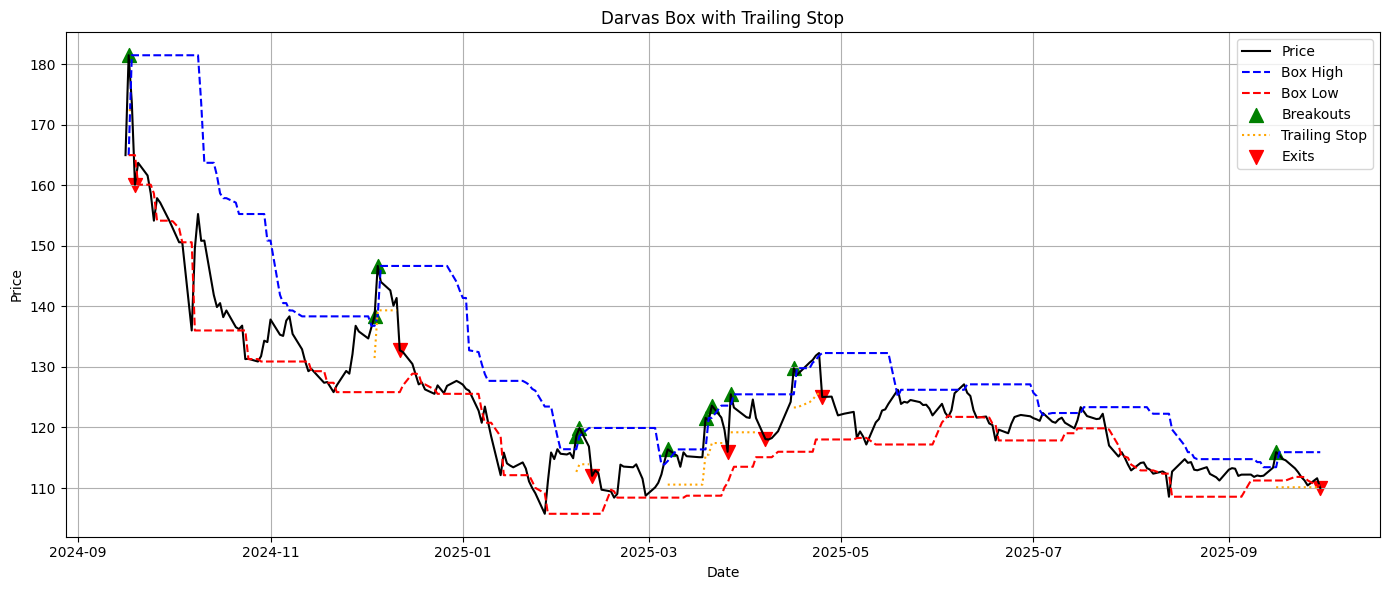

In [53]:
# Step 1: Detect breakouts
col = 'BAJAJHFL.NS'
result = detect_darvas_breakouts(df, symbol_col=col, box_lookback=15)

# Step 2: Apply trailing stop
result = apply_trailing_stop(result, symbol_col=col, stop_pct=0.05)

# Step 3: Plot it all
plot_darvas_with_trailing_stop(result, symbol_col=col)


## Performance tracking

In [37]:
def generate_trades(df, symbol_col='ITC.NS'):
    """
    Generate a trade log and equity curve from Darvas breakouts + trailing stop logic.

    Returns:
        trades_df (DataFrame): List of trades with entry/exit prices, dates, return per trade.
        equity_df (DataFrame): Portfolio equity over time.
    """
    trades = []
    in_trade = False
    entry_price = None
    entry_date = None
    cash = 5_000  # Starting capital
    position_size = 1.0  # Invest 100% each trade
    equity_curve = []

    for i in range(len(df)):
        row = df.iloc[i]
        price = row[symbol_col]
        date = row.name

        if not in_trade and row['breakout']:
            in_trade = True
            entry_price = price
            entry_date = date
        elif in_trade and row['exit']:
            # Exit trade
            exit_price = price
            exit_date = date
            pct_return = (exit_price - entry_price) / entry_price
            pnl = cash * pct_return * position_size
            cash += pnl
            trades.append({
                'Entry Date': entry_date,
                'Exit Date': exit_date,
                'Entry Price': entry_price,
                'Exit Price': exit_price,
                'Return %': pct_return * 100,
                'PnL': pnl,
                'Equity': cash
            })
            in_trade = False
            entry_price = None
            entry_date = None

        # Record equity daily (for curve)
        equity_curve.append({'Date': date, 'Equity': cash})

    trades_df = pd.DataFrame(trades)
    equity_df = pd.DataFrame(equity_curve).set_index('Date')
    return trades_df, equity_df


In [16]:
def plot_equity_curve(equity_df):
    plt.figure(figsize=(12, 4))
    plt.plot(equity_df.index, equity_df['Equity'], label='Equity Curve', color='purple', linewidth=2)
    plt.title('Darvas Box Strategy: Equity Curve')
    plt.ylabel('Portfolio Value')
    plt.xlabel('Date')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [21]:
# Step 1: Detect breakouts
result = detect_darvas_breakouts(df, symbol_col='ITC.NS', box_lookback=15)

# Step 2: Apply trailing stop
result = apply_trailing_stop(result, symbol_col='ITC.NS', stop_pct=0.05)

# Step 3: Run backtest
trades_df, equity_df = generate_trades(result, symbol_col='ITC.NS')

# Step 4: Review results
print(f"\nTotal Return: {((equity_df['Equity'].iloc[-1] / equity_df['Equity'].iloc[0]) - 1) * 100:.2f}%")

# Step 5: Plot equity
# plot_equity_curve(equity_df)



Total Return: 35.41%


In [ ]:
for symbol in df.columns:

    result = detect_darvas_breakouts(df, symbol_col=symbol, box_lookback=15)
    
    result = apply_trailing_stop(result, symbol_col=symbol, stop_pct=0.05)
    
    trades_df, equity_df = generate_trades(result, symbol_col=symbol)
    
    print(f"{symbol} Total Return: {((equity_df['Equity'].iloc[-1] / equity_df['Equity'].iloc[0]) - 1) * 100:.2f}%")

## Darvas Box Multi-Stock Simulation with Adaptive Buffer

In [ ]:
def calculate_transaction_charges(trade_value, is_buy=True):
    """
    Calculate total transaction cost for a trade value.
    
    Args:
        trade_value (float): Total value of the trade (price * quantity).
        is_buy (bool): True for buy leg, False for sell leg.
    
    Returns:
        float: Total cost of transaction.
    """
    brokerage = max(5, min(20, 0.001 * trade_value))  # 0.1%, bounded between ₹5 and ₹20
    stt = 0.001 * trade_value                         # 0.1%
    turnover = 0.000001 * trade_value                 # 0.0001%
    stamp_duty = 0.001 * trade_value if is_buy else 0  # Only on buy
    
    total_cost = brokerage + stt + turnover + stamp_duty
    return total_cost

In [100]:
def detect_darvas_breakouts(df, symbol_col, box_lookback=5, breakout_buffer=0.01):
    df = df.copy()  # Make a copy to avoid modifying slice of original df
    df['box_high'] = df[symbol_col].rolling(window=box_lookback, min_periods=1).max().shift(1)
    df['box_low'] = df[symbol_col].rolling(window=box_lookback, min_periods=1).min().shift(1)
    threshold = df['box_high'] * (1 + breakout_buffer)
    df['breakout'] = (df[symbol_col] > threshold) & df['box_high'].notnull()
    return df

In [101]:
def simulate_darvas_multistock(data, box_lookback=5, initial_buffer=0.01, stop_pct=0.05, stack_size=2):
    results = {}
    capital = 500

    for symbol in data.columns:
        df = pd.DataFrame()
        df[symbol] = data[symbol]
        df = df.dropna()

        buffer = initial_buffer
        failed_trades = 0
        in_trade = False
        pending_breakouts = 0
        entry_price = None
        highest_price = None
        trades = []
        cash = capital

        df = detect_darvas_breakouts(df, symbol_col=symbol, box_lookback=box_lookback, breakout_buffer=buffer)

        for i in range(len(df)):
            row = df.iloc[i]
            price = row[symbol]
            date = df.index[i]

            if not in_trade and row['breakout']:
                if pending_breakouts == (stack_size - 1):
                    # 🚀 Enter trade on Nth breakout
                    entry_price = price
                    position_value = cash
                    buy_fees = calculate_transaction_charges(position_value, is_buy=True)
                    if buy_fees >= cash:
                        continue  # Not enough cash after fees
                    position_size = (cash - buy_fees) / entry_price
                    cash -= (position_size * entry_price + buy_fees)

                    highest_price = price
                    trailing_stop = price * (1 - stop_pct)
                    entry_date = date
                    in_trade = True
                    pending_breakouts = 0  # reset
                else:
                    pending_breakouts += 1

            elif in_trade:
                if price > highest_price:
                    highest_price = price
                    trailing_stop = highest_price * (1 - stop_pct)

                if price < trailing_stop:
                    exit_price = price
                    exit_value = exit_price * position_size
                    sell_fees = calculate_transaction_charges(exit_value, is_buy=False)
                    net_exit = exit_value - sell_fees
                    cash += net_exit

                    return_pct = (net_exit - (position_size * entry_price + buy_fees)) / (position_size * entry_price + buy_fees)
                    pnl = net_exit - (position_size * entry_price + buy_fees)

                    trades.append({
                        'Entry Date': entry_date,
                        'Exit Date': date,
                        'Entry Price': entry_price,
                        'Exit Price': exit_price,
                        'Shares': position_size,
                        'Buy Fees': buy_fees,
                        'Sell Fees': sell_fees,
                        'Total Fees': buy_fees + sell_fees,
                        'PnL': pnl,
                        'Return %': return_pct * 100,
                        'Buffer': buffer
                    })

                    if pnl < 0:
                        failed_trades += 1
                        if failed_trades >= 3:
                            buffer += 0.005
                            failed_trades = 0
                    else:
                        failed_trades = 0

                    # Reset state
                    in_trade = False
                    entry_price = None
                    highest_price = None
                    pending_breakouts = 0

                    # Recompute breakouts if buffer updated
                    updated_part = detect_darvas_breakouts(
                        df.iloc[i:].copy(), symbol_col=symbol,
                        box_lookback=box_lookback, breakout_buffer=buffer
                    )
                    df.loc[df.index[i:], ['box_high', 'box_low', 'breakout']] = updated_part[['box_high', 'box_low', 'breakout']]

        results[symbol] = {
            'Trades': pd.DataFrame(trades),
            'Final Cash': cash,
            'Return %': ((cash - capital) / capital) * 100,
            'Buffer': buffer
        }

    return results



In [108]:
results = simulate_darvas_multistock(df, box_lookback=15, initial_buffer=0.01, stop_pct=0.05, stack_size=3)

In [109]:
initial_cash = 500*200
total = int(sum(r['Final Cash'] for r in results.values()))
print('Returns %: ', (total-initial_cash)/initial_cash*100)

Returns %:  8.466999999999999


###  Grid search for best paramter values

In [121]:
from itertools import product
from tqdm import tqdm

box_lookback_vals=[3, 5, 10, 15, 30]
initial_buffer_vals=[0.005, 0.01, 0.02]
stop_pct_vals=[0.03, 0.05, 0.07]
stack_size_vals=[1, 2, 3]
param_grid = list(product(
        box_lookback_vals,
        initial_buffer_vals,
        stop_pct_vals,
        stack_size_vals
    ))
total_runs = len(param_grid)

grid_result=[]

initial_cash = 500*200

for i, (box_lookback, buffer, stop_pct, stack_size) in tqdm(enumerate(param_grid)):
    sim_result = simulate_darvas_multistock(df, box_lookback=box_lookback, initial_buffer=buffer, stop_pct=stop_pct, stack_size=stack_size)
    total = int(sum(r['Final Cash'] for r in sim_result.values()))
    avg_return = (total-initial_cash)/initial_cash*100
    total_trades = sum(len(stock['Trades']) for stock in sim_result.values())
    grid_result.append({
            'box_lookback': box_lookback,
            'initial_buffer': buffer,
            'stop_pct': stop_pct,
            'stack_size': stack_size,
            'average_return_pct': avg_return,
            'total_trades': total_trades
        })


135it [20:48,  9.24s/it]


In [122]:
for i, result in enumerate(grid_result):
    print(f"Set {i+1}/{total_runs} → box_lookback={result['box_lookback']}, initial_buffer={result['initial_buffer']}, stop={result['stop_pct']}, stack={result['stack_size']}, Returns % = {result['average_return_pct']}")


Set 1/135 → box_lookback=3, initial_buffer=0.005, stop=0.03, stack=1, Returns % = 45.751999999999995
Set 2/135 → box_lookback=3, initial_buffer=0.005, stop=0.03, stack=2, Returns % = 38.979
Set 3/135 → box_lookback=3, initial_buffer=0.005, stop=0.03, stack=3, Returns % = 27.816999999999997
Set 4/135 → box_lookback=3, initial_buffer=0.005, stop=0.05, stack=1, Returns % = 18.083
Set 5/135 → box_lookback=3, initial_buffer=0.005, stop=0.05, stack=2, Returns % = 12.442
Set 6/135 → box_lookback=3, initial_buffer=0.005, stop=0.05, stack=3, Returns % = 8.698
Set 7/135 → box_lookback=3, initial_buffer=0.005, stop=0.07, stack=1, Returns % = -19.225
Set 8/135 → box_lookback=3, initial_buffer=0.005, stop=0.07, stack=2, Returns % = -18.35
Set 9/135 → box_lookback=3, initial_buffer=0.005, stop=0.07, stack=3, Returns % = -17.182
Set 10/135 → box_lookback=3, initial_buffer=0.01, stop=0.03, stack=1, Returns % = 45.524
Set 11/135 → box_lookback=3, initial_buffer=0.01, stop=0.03, stack=2, Returns % = 30.